    Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

Load the Dataset

In [3]:
df=pd.read_csv("C:/Users/NEPHIC  840G3/Desktop/FYJ/DATA_ANALYSIS FILES/sales_data.csv")

Display basic information

In [4]:
# Checking the first 5 rows of the dataset
df.head()

,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
0,1052,03/02/2023,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
1,1093,21/04/2023,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2,1015,21/09/2023,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
3,1072,24/08/2023,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
4,1061,24/03/2023,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [5]:
# Checking the structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product_ID            1000 non-null   int64  
 1   Sale_Date             1000 non-null   object 
 2   Sales_Rep             1000 non-null   object 
 3   Region                1000 non-null   object 
 4   Sales_Amount          1000 non-null   float64
 5   Quantity_Sold         1000 non-null   int64  
 6   Product_Category      1000 non-null   object 
 7   Unit_Cost             1000 non-null   float64
 8   Unit_Price            1000 non-null   float64
 9   Customer_Type         1000 non-null   object 
 10  Discount              1000 non-null   float64
 11  Payment_Method        1000 non-null   object 
 12  Sales_Channel         1000 non-null   object 
 13  Region_and_Sales_Rep  1000 non-null   object 
dtypes: float64(4), int64(2), object(8)
memory usage: 109.5+ KB


Data Cleaning and Preprocessing

In [8]:
# Convert Sale_Date to dateframe format
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'], format='%d/%m/%Y')

In [9]:
# Extract month from Sale_Date
df['Month']=df['Sale_Date'].dt.month
#Aggregate total sales per month
monthly_sales=df.groupby('Month')['Sales_Amount'].sum()

In [10]:
# Checking for missing values
missing_values=df.isnull().sum()
missing_values

Product_ID              0
Sale_Date               0
Sales_Rep               0
Region                  0
Sales_Amount            0
Quantity_Sold           0
Product_Category        0
Unit_Cost               0
Unit_Price              0
Customer_Type           0
Discount                0
Payment_Method          0
Sales_Channel           0
Region_and_Sales_Rep    0
Month                   0
dtype: int64

In [11]:
# Removing duplicates if any
df=df.drop_duplicates()

In [13]:
# Create new calculated columns
df['Profit']=df['Unit_Price']-df['Unit_Cost']
df['Discounted_Price']=df['Unit_Price']*(1-df['Discount'])

In [14]:
df.head()

,Product_ID,Sale_Date,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep,Month,Profit,Discounted_Price
0,1052,2023-02-03,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob,2,114.47,243.1702
1,1093,2023-04-21,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob,4,393.05,3746.4016
2,1015,2023-09-21,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David,9,109.84,297.1200
3,1072,2023-08-24,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob,8,137.72,4378.3950
4,1061,2023-03-24,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie,3,55.34,637.2932


2. Exploratory Data Analysis(EDA)

In [15]:
# Summary Statistics
df.describe()

,Product_ID,Sale_Date,Sales_Amount,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Month,Profit,Discounted_Price
count,1000.000000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000
mean,1050.128000,2023-07-02 17:42:43.199999744,5019.265230,25.355000,2475.304550,2728.440120,0.15239,6.50600,253.135570,2314.758456
min,1001.000000,2023-01-01 00:00:00,100.120000,1.000000,60.280000,167.120000,0.00000,1.00000,10.310000,127.134000
25%,1024.000000,2023-03-30 00:00:00,2550.297500,13.000000,1238.380000,1509.085000,0.08000,3.00000,133.647500,1275.210850
50%,1051.000000,2023-06-30 12:00:00,5019.300000,25.000000,2467.235000,2696.400000,0.15000,6.00000,256.525000,2303.299100
75%,1075.000000,2023-10-12 00:00:00,7507.445000,38.000000,3702.865000,3957.970000,0.23000,10.00000,367.607500,3313.787425
max,1100.000000,2024-01-01 00:00:00,9989.040000,49.000000,4995.300000,5442.150000,0.30000,12.00000,499.930000,5402.280000
std,29.573505,NaN,2846.790126,14.159006,1417.872546,1419.399839,0.08720,3.54154,141.081466,1233.852015


In [16]:
# Ensuring proper sorting by date
df=df.sort_values(by="Sale_Date")

In [17]:
# Check for missing values
missing_values=df.isnull().sum()
missing_values

Product_ID              0
Sale_Date               0
Sales_Rep               0
Region                  0
Sales_Amount            0
Quantity_Sold           0
Product_Category        0
Unit_Cost               0
Unit_Price              0
Customer_Type           0
Discount                0
Payment_Method          0
Sales_Channel           0
Region_and_Sales_Rep    0
Month                   0
Profit                  0
Discounted_Price        0
dtype: int64

In [19]:
# filling missing values if any
df.ffill(inplace=True)

In [21]:
# Aggregate sales over time
df_sales=df.groupby('Sale_Date')["Sales_Amount"].sum().reset_index()
df_sales

,Sale_Date,Sales_Amount
0,2023-01-01,14141.12
1,2023-01-02,6452.79
2,2023-01-03,21319.08
3,2023-01-04,30175.06
4,2023-01-05,16708.75
...,...,...
335,2023-12-28,7976.44
336,2023-12-29,20842.53
337,2023-12-30,26107.95
338,2023-12-31,28608.37


In [27]:
# Detect outliers using IQR
# Calculating Q1( 25th Percentile and Q3( 75th percentile)
Q1=df_sales["Sales_Amount"].quantile(0.25)
Q3=df_sales["Sales_Amount"].quantile(0.75)
IQR=Q3-Q1

# set bounds for outliers
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
# Detect outliers
outliers=df_sales[(df_sales["Sales_Amount"]<lower_bound)|(df_sales["Sales_Amount"]>upper_bound)]

#Print results
print("Outliers:")
print(outliers)

Outliers:
     Sale_Date  Sales_Amount
11  2023-01-12      43522.74
213 2023-08-14      38964.86
268 2023-10-15      43628.04
269 2023-10-16      41683.41
272 2023-10-20      51695.71
304 2023-11-24      40711.70
330 2023-12-22      37678.67


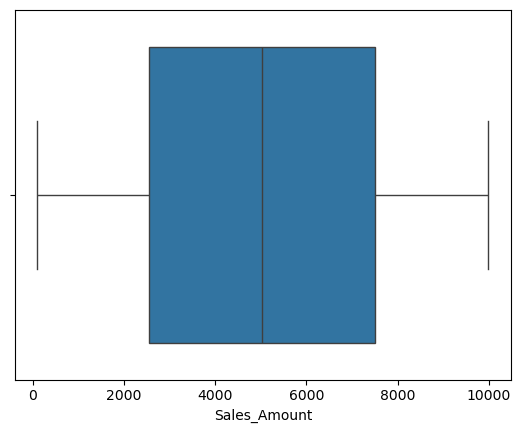

In [28]:
# Detect Outliers using Boxplots
sns.boxplot(x=df['Sales_Amount'])
plt.show()            

Visualizations & Insights

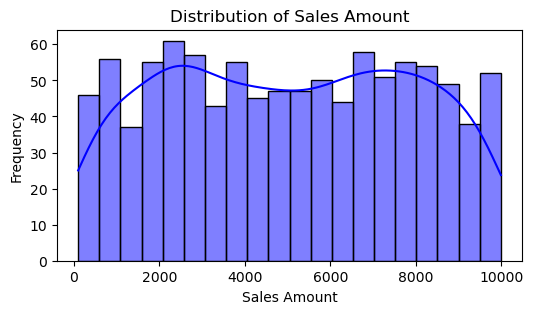

In [29]:
# Sales Distribution
plt.figure(figsize=(6,3))
sns.histplot(df['Sales_Amount'],bins=20,kde=True,color='Blue')
print()
plt.title('Distribution of Sales Amount')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.show()

Profit Distribution(Histogram)

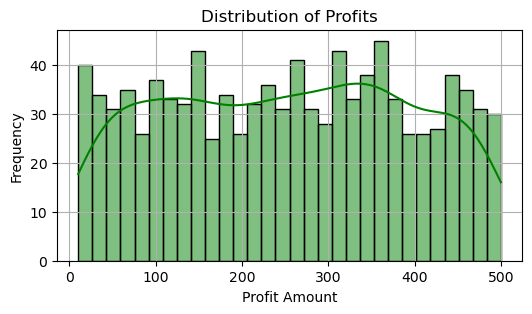

In [35]:
plt.figure(figsize=(6,3))
sns.histplot(df["Profit"],bins=30,color='green',kde=True)
plt.title("Distribution of Profits")
plt.xlabel("Profit Amount")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Comparing Sales Performance

In [43]:
# Group data by Customer Type
sales_comparison=df.groupby("Customer_Type").agg({
    "Sales_Amount":["sum","mean"],
                    "Quantity_Sold":"sum","Discount": "mean"}).reset_index()
sales_comparison

Customer_Type Sales_Amount              Quantity_Sold  Discount
                         sum         mean           sum      mean
0           New   2506258.30  4972.734722         13184  0.151726
1     Returning   2513006.93  5066.546230         12171  0.153065

In [45]:
# Rename Columns for Clarity
sales_comparison.columns=["Customer Type","Total Sales","Avg Sales per Transaction","Total Quantity Sold","Avg Discount Applied"]

# Display the Summary
sales_comparison

,Customer Type,Total Sales,Avg Sales per Transaction,Total Quantity Sold,Avg Discount Applied
0,New,2506258.30,4972.734722,13184,0.151726
1,Returning,2513006.93,5066.546230,12171,0.153065


Visualizations

C:\Users\NEPHIC  840G3\AppData\Local\Temp\ipykernel_10224\4014258759.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_comparison["Customer Type"],


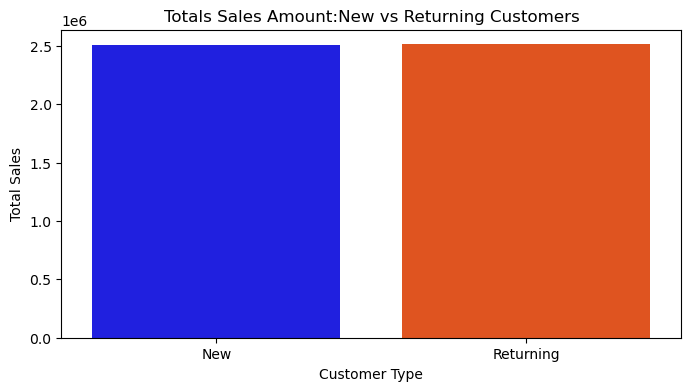

In [57]:
# Total Sales Amount by Customer Type
plt.figure(figsize=(8,4))
sns.barplot(x=sales_comparison["Customer Type"],
            y=sales_comparison["Total Sales"],
           palette=["blue","orangered"])
plt.title("Totals Sales Amount:New vs Returning Customers")
plt.xlabel("Customer Type")
plt.ylabel("Total Sales")
plt.show()

**Explanations of the above Bar Charts**
**(1) Balanced Sales Contribution:**
    .The total sales from new customers and returning customers are nearly identical, both reaching approximately $2.5 million.
    .This suggests the business is generating revenue from both acquiring new customers and retaining existing customers.
**(2) Stable Revenue Model:**
    .The company has two strong customer streams, ensuring a steady cashflow without relying too much on one group
**(3) Growth Strategy Insights:**
   *For New Customers;*
      - Maintaining strong marketing and advertising compaigns can continue attracting new buyers.
      - Improving the onboarding &first-purchase experience can encourage future retention.
   *For Returning Customers;*
      - A strong loyalty program could further increase repeat purchases.
      - Offering personalized discounts or rewards may strengthen customer retention.

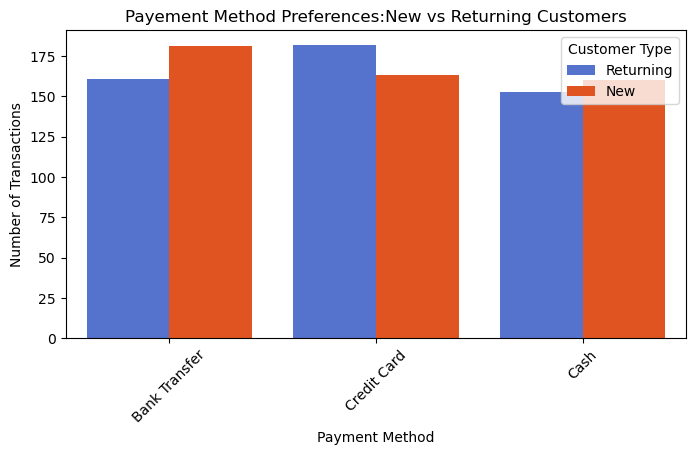

In [62]:
# Analyzing Payment Method Preferences by Customers
plt.figure(figsize=(8,4))
sns.countplot(data=df,
              x="Payment_Method",
              hue="Customer_Type",
              palette=["royalblue","orangered"])
plt.title("Payement Method Preferences:New vs Returning Customers")
plt.xlabel("Payment Method")
plt.ylabel("Number of Transactions")
plt.legend(title="Customer Type")
plt.xticks(rotation=45)
plt.show()

**Payment Method Preferences: New vs.Returning Customers**

Understanding how **new** and **returning** customers prefer to pay can help businesses optimize their payment strategies. This analysis compares their number of transactions across three three payment methods: **Cash**,**Credit Card**,**Bank Transfer**

**Key Insights& Trends**

**1.Cash Payment**- *New Customers* slightly prefer cash over returning customers.
                  - *Returning Customers* still use cash but not as their top choice

**Takeaway:** Cash is still relevant but not the most prefered option for either group

**2.Bank Transfer**-*New customers*prefer bank transfers the most
                   -*Returning customers*use this method less frequently
**Possible Reason? New customers may find direct bank payments safer or more accessible

**3.Credit Card**-*Returning customers favor credit card the most
                 -*New customers also use credit cards but slightly less
**Why?** Returning customers likely have saved their detaols, making repeat purchases smoother



**Visual Breakdown**

The bar chart shows:
-Returning customers prefer credit cards , followed by bank transfers and cash.
-New customers go for bank transfers first, followed by credit cards and cash.

📌 **Next Steps & Recommendations**
For Businesses:
🔹 Encourage returning customers with loyalty rewards for credit card transactions. 
🔹 Boost new customer conversions by offering bank transfer discounts or bonuses. 
🔹 Consider adding seamless payment options like digital wallets  to cater to both groups

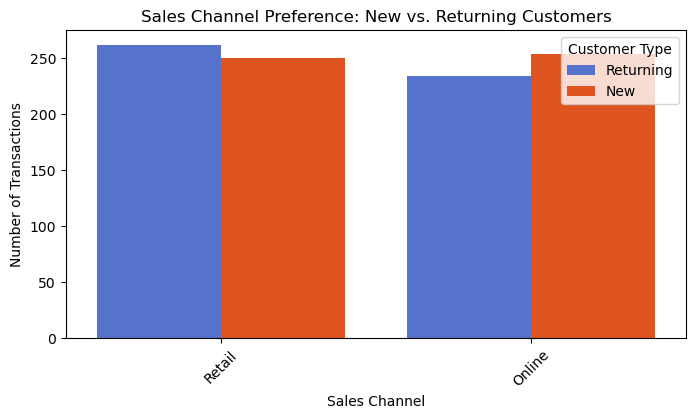

In [63]:
# Analyzing Sales Channel Preferences by Customer Type
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="Sales_Channel", hue="Customer_Type", palette=["royalblue", "orangered"])
plt.title("Sales Channel Preference: New vs. Returning Customers")
plt.xlabel("Sales Channel")
plt.ylabel("Number of Transactions")
plt.legend(title="Customer Type")
plt.xticks(rotation=45)
plt.show()

🔍 **Key Insights & Observations**
1️⃣ **Online Sales** 

✔️ New customers slightly prefer online shopping over returning customers.
✔️ Returning customers still make a significant number of online purchases but are slightly behind new customers.
💡 **Possible Explanation?** New customers may be exploring convenience, promotions, or first-time online discounts.

2️⃣ **Retail Sales**

✔️ Returning customers prefer shopping in retail stores more than new customers.
✔️ New customers still shop in retail but at a slightly lower rate.
💡 Why? Returning customers may trust in-person shopping more, prefer personalized service, or enjoy the shopping experience.

📌 **Business Strategy Recommendations**

✅ **For Online Growth:**
🔹 Offer personalized discounts for returning customers to increase online shopping. 
🔹 Create easy onboarding & first-time discounts for new customers to retain them. 

✅ **For Retail Growth:**
🔹 Enhance in-store experiences (e.g., loyalty programs, exclusive discounts) to attract new customers. 
🔹 Use omnichannel strategies (e.g., buy online, pick up in-store) to merge both customer groups

C:\Users\NEPHIC  840G3\AppData\Local\Temp\ipykernel_10224\936868362.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_comparison["Customer Type"], y=sales_comparison["Total Quantity Sold"], palette=["royalblue", "orangered"])


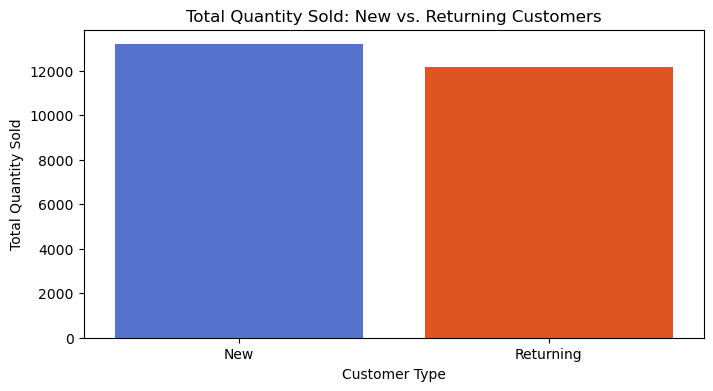

In [64]:
# Visualization - Total Quantity Sold
plt.figure(figsize=(8, 4))
sns.barplot(x=sales_comparison["Customer Type"], y=sales_comparison["Total Quantity Sold"], palette=["royalblue", "orangered"])
plt.title("Total Quantity Sold: New vs. Returning Customers")
plt.ylabel("Total Quantity Sold")
plt.xlabel("Customer Type")
plt.show()

New customers purchased slightly more items overall than returning customers.Returning customers still show a strong purchase volume, which is a good sign of customer loyalty.

C:\Users\NEPHIC  840G3\AppData\Local\Temp\ipykernel_10224\2623912628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


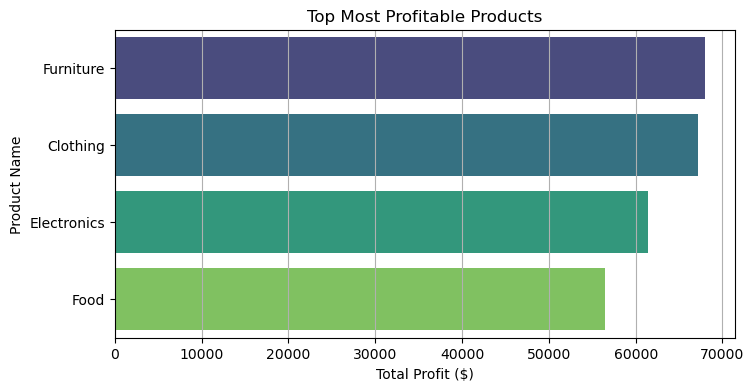

In [65]:
# Top Most Profitable Category (Bar Chart)
plt.figure(figsize=(8, 4))
top_products = df.groupby("Product_Category")["Profit"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top Most Profitable Products")
plt.xlabel("Total Profit ($)")
plt.ylabel("Product Name")
plt.grid(axis="x")
plt.show()

This horizontal bar chart visualizes the total profit generated by the top 10 most profitable product categories in the dataset. The bars represent cumulative profit for each category, allowing us to compare which product types contribute the most to overall profitability

**Sales Trend**

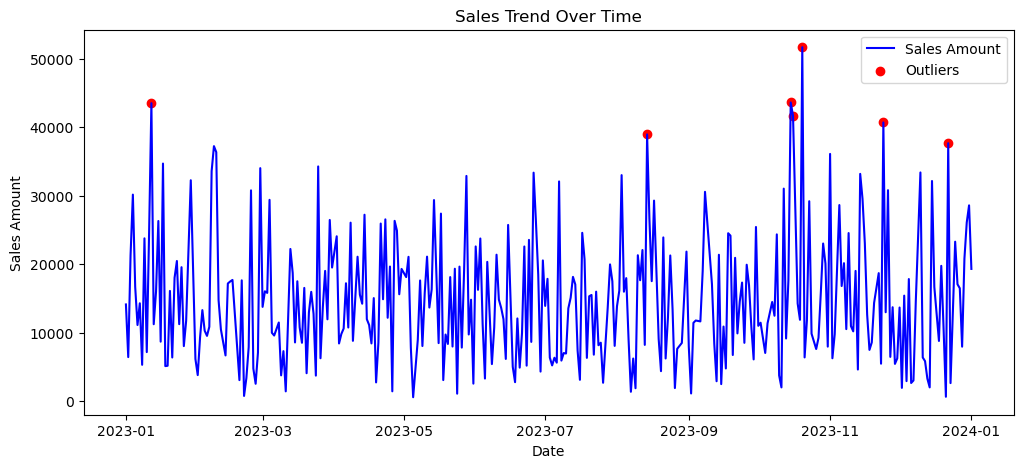

In [66]:
# Plot sales trend with outliers
plt.figure(figsize=(12,5))
plt.plot(df_sales["Sale_Date"], df_sales["Sales_Amount"], label="Sales Amount", color="blue")
plt.scatter(outliers["Sale_Date"], outliers["Sales_Amount"], color="red", label="Outliers")
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.legend()
plt.show()

This graph presents a detailed analysis of sales trends over time, pinpointing significant anomalies (outliers) that may indicate special events, irregular demand spikes, or data inconsistencies

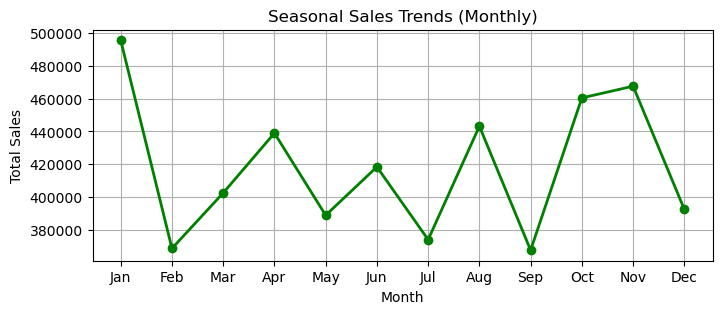

In [71]:
# Plot sales trends over months
plt.figure(figsize=(8,3))
monthly_sales.plot(kind='line', marker='o', color='green', linewidth=2)
plt.xticks(ticks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Seasonal Sales Trends (Monthly)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

**High sales in January, followed by a sharp decline in February**

Sales start very high in January (~500,000) but drop significantly in February (~370,000).
This suggests a strong start to the year, possibly due to post-holiday shopping or a New Year promotional boost, followed by a natural decline.
2️⃣ Fluctuating sales pattern throughout the year

Sales rise and fall multiple times rather than following a consistent trend.
This indicates seasonal effects, marketing efforts, or external factors affecting demand.
3️⃣ Sales spikes in April, August, October, and November

April and August show noticeable peaks, suggesting possible seasonal promotions or product launches.
October and November have the highest increases after January, likely due to holiday shopping and Black Friday sales.
4️⃣ Lowest sales in February and September

February’s drop could be due to a post-holiday spending slowdown.
September’s decline may indicate a pre-holiday lull before Q4 shopping increases

C:\Users\NEPHIC  840G3\AppData\Local\Temp\ipykernel_10224\967786341.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_reps.index, y=top_reps.values, palette='viridis')


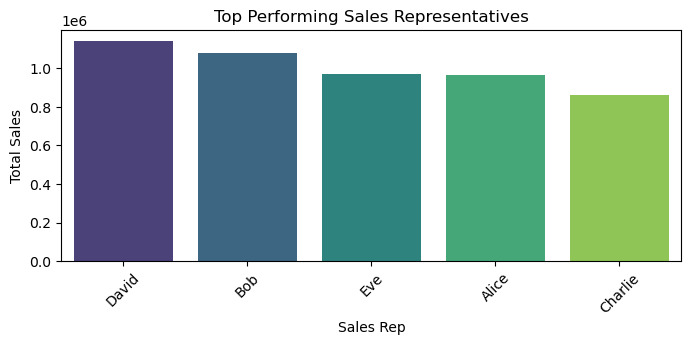

In [72]:
# Top Sales Representatives
top_reps = df.groupby('Sales_Rep')['Sales_Amount'].sum().sort_values(ascending=False)
plt.figure(figsize=(8,3))
sns.barplot(x=top_reps.index, y=top_reps.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top Performing Sales Representatives')
plt.xlabel('Sales Rep')
plt.ylabel('Total Sales')
plt.show()

C:\Users\NEPHIC  840G3\AppData\Local\Temp\ipykernel_10224\2013816513.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")


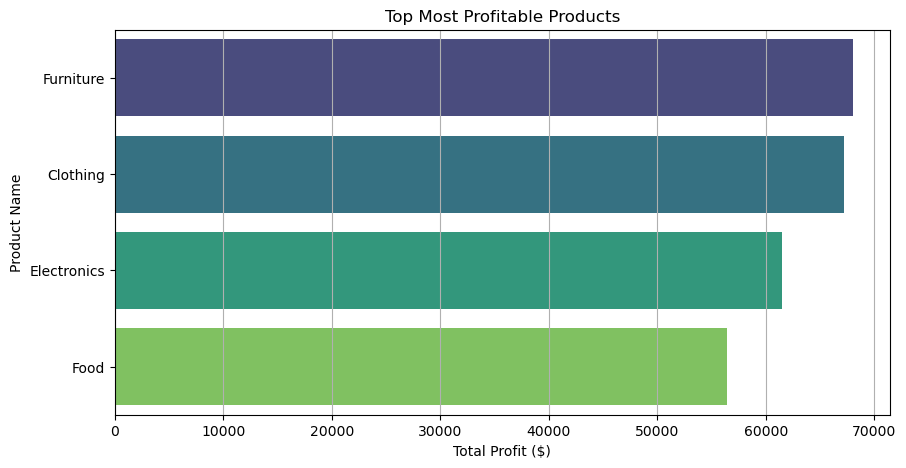

In [73]:
# 3️⃣ Top 10 Most Profitable Products (Bar Chart)
plt.figure(figsize=(10, 5))
top_products = df.groupby("Product_Category")["Profit"].sum().sort_values(ascending=False).head(10)
sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
plt.title("Top Most Profitable Products")
plt.xlabel("Total Profit ($)")
plt.ylabel("Product Name")
plt.grid(axis="x")
plt.show()

C:\Users\NEPHIC  840G3\AppData\Local\Temp\ipykernel_10224\2335154624.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Region'], y=df['Sales_Amount'], palette='Set2')


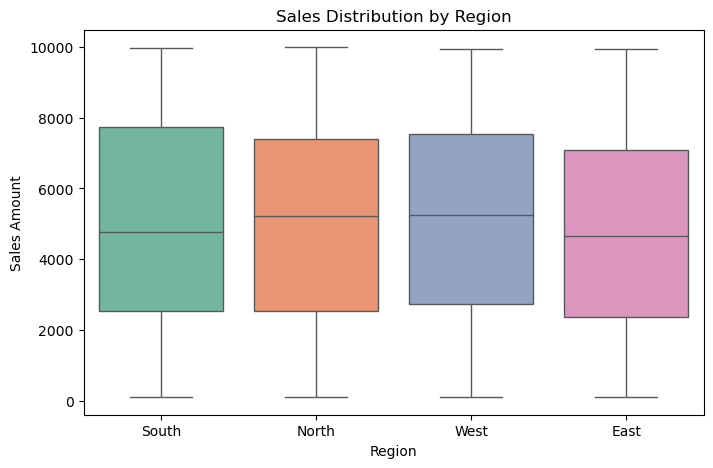

In [74]:
# Sales by Region
plt.figure(figsize=(8,5))
sns.boxplot(x=df['Region'], y=df['Sales_Amount'], palette='Set2')
plt.title('Sales Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Sales Amount')
plt.show()